# 1 Предобработка

### 1.1 Очистка и нормализация текста

In [ ]:
import pandas as pd

data = pd.read_csv(
    r'raw_dataset.csv',
    encoding='latin-1',
    header=None,
    names=['target', 'id', 'date', 'flag', 'user', 'text']
)

data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<Axes: >

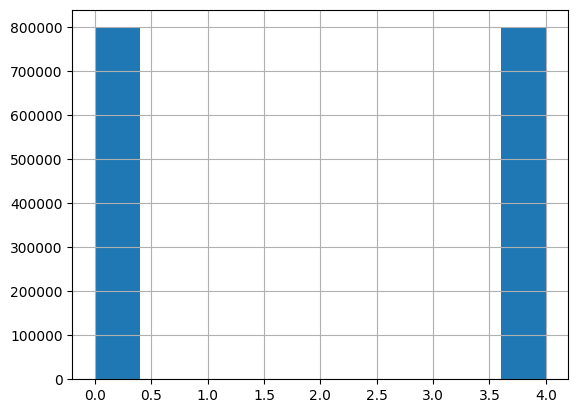

In [2]:
data['target'].hist()

В нижний регистр

In [3]:
text_lower = data['text'].str.lower()

text_lower

0          @switchfoot http://twitpic.com/2y1zl - awww, t...
1          is upset that he can't update his facebook by ...
2          @kenichan i dived many times for the ball. man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, Length: 1600000, dtype: object

Удаление ссылок итд + удаление дубликатов

In [4]:
import re

# ссылки и домены
URL_RE = re.compile(r'(https?://\S+|www\.\S+|[a-zA-Z0-9\-]+\.[a-zA-Z]{2,})')
# упоминания
MENTION_RE = re.compile(r'@\w+')
# хэштеги
HASHTAG_RE = re.compile(r'#\w+')

# оставить только латиницу/цифры/пробелы и пунктуацию . , '
ALLOWED_CHARS_RE = re.compile(r"[^a-z0-9\s\.\,']")

# схлопывание повторов:
# 1) буквы: 3+ одинаковых подряд -> 2 (cooool -> coool -> coo)
LETTER_RUNS_RE = re.compile(r'([a-z])\1{2,}')
# 2) пунктуация . , ' : 2+ -> 1 (.... -> .  ,, -> ,  ''' -> ')
PUNCT_RUNS_RE = re.compile(r"([\.\,'])\1+")

def clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()

    # убрать ссылки/упоминания/хэштеги
    text = URL_RE.sub(" ", text)
    text = MENTION_RE.sub(" ", text)
    text = HASHTAG_RE.sub(" ", text)

    # убрать все, кроме [a-z0-9] пробелов и . , '
    text = ALLOWED_CHARS_RE.sub(" ", text)

    # схлопнуть длинные буквы (оставить максимум две подряд)
    text = LETTER_RUNS_RE.sub(r"\1\1", text)

    # схлопнуть повторы пунктуации до одной
    text = PUNCT_RUNS_RE.sub(r"\1", text)

    # убрать лишние пробелы
    text = re.sub(r"\s+", " ", text).strip()
    return text



clean_text_lower = text_lower.apply(clean)
clean_text_lower = clean_text_lower.drop_duplicates().reset_index(drop=True)

clean_text_lower

0          aww, that's a bummer. you shoulda got david ca...
1          is upset that he can't update his facebook by ...
2          i dived many times for the ball. managed to sa...
3             my whole body feels itchy and like its on fire
4          no, it's not behaving at all. i'm mad. why am ...
                                 ...                        
1526945    yeah, that does work better than just waiting ...
1526946    just woke up. having no school is the best fee...
1526947                very cool to hear old walt interviews
1526948    are you ready for your mojo makeover ask me fo...
1526949    happy 38th birthday to my boo of all time tupa...
Name: text, Length: 1526950, dtype: object

Статистика

count    19904174.00
mean            4.09
std             2.15
min             1.00
25%             3.00
50%             4.00
75%             5.00
max           112.00
Name: word_len, dtype: float64


<Axes: >

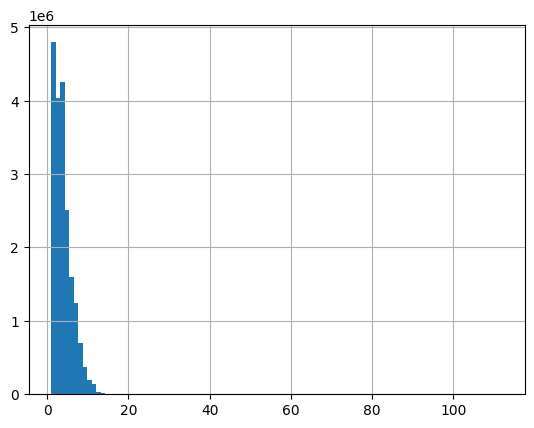

In [5]:
lengths = [len(w) for s in clean_text_lower for w in s.split()]


print(pd.Series(lengths, name="word_len").describe().round(2))
pd.Series(lengths, name="word_len").hist(bins = 100)

### 1.2 Токенизация

In [6]:
from transformers import AutoTokenizer
import numpy as np


tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)        
tokenizer.add_special_tokens({"pad_token": "<PAD>"})     
EOS = tokenizer.eos_token_id

texts = clean_text_lower.astype(str).tolist()

enc = tokenizer(
    texts,
    add_special_tokens=False,
    padding=False,
    truncation=False          
)

sequences = []
for ids in enc["input_ids"]:
    if not ids:
        continue
    sequences.append(ids + [EOS])

lens = np.array([len(s) for s in sequences])
print(f"Количество твитов: {len(lens)}")
print(f"min/median/mean/max: {lens.min()} / {np.median(lens):.1f} / {lens.mean():.1f} / {lens.max()}")
for q in [50, 75, 90, 95, 99]:
    print(f"p{q}: {int(np.percentile(lens, q))}")

Количество твитов: 1526949
min/median/mean/max: 2 / 16.0 / 17.3 / 99
p50: 16
p75: 24
p90: 30
p95: 32
p99: 37


### 1.3 Разделение на трейн, валидацию и тест

In [ ]:
import json
from sklearn.model_selection import train_test_split

train_seqs, temp = train_test_split(sequences, test_size=0.2, random_state=42, shuffle=True)
val_seqs,   test_seqs = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True)


with open("data/train.json", "w", encoding="utf-8") as f:
    json.dump(train_seqs, f, ensure_ascii=False, separators=(",", ":"))
with open("data/val.json", "w", encoding="utf-8") as f:
    json.dump(val_seqs, f, ensure_ascii=False, separators=(",", ":"))
with open("data/test.json", "w", encoding="utf-8") as f:
    json.dump(test_seqs, f, ensure_ascii=False, separators=(",", ":"))

: 

## 2 Обучение модели

In [ ]:
import pandas as pd
import ast
import os
from tqdm import tqdm
import numpy as np
import torch
import json
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer

from src.dataset import NextTokenDataset
from src.model import RNNAutocompletion
from src.utils import free_gen_rougeL


TRAIN_DATA_PATH = r"data\train.json"
VALID_DATA_PATH = r"data\val.json"
EXP_NAME = "exp1"
CHUNK_LEN = 32
STRIDE = CHUNK_LEN
EPOCHS = 301
BATCH_SIZE = 256
LR = 2e-3
DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.3

EVAL_EVERY = 10
EVAL_K_LIST = (1, 7, 21, 28)
REF_MAX_TOKENS = 32
GEN_MAX_NEW_TOKENS = REF_MAX_TOKENS
SAMPLES_PER_K = 10


with open(TRAIN_DATA_PATH, "r", encoding="utf-8") as f:
    train_sequences = json.load(f)  

with open(VALID_DATA_PATH, "r", encoding="utf-8") as f:
    valid_sequences = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = "cuda" if device.type == "cuda" else "cpu"
print(f"device: {device}")

tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
tokenizer.add_special_tokens({"pad_token": "<PAD>"})
pad_token_id = tokenizer.pad_token_id
eos_token_id = tokenizer.eos_token_id
vocab_size = len(tokenizer)

dataset_train = NextTokenDataset(train_sequences, chunk_length=CHUNK_LEN, stride=STRIDE, offset=0)
dataset_val = NextTokenDataset(valid_sequences, chunk_length=CHUNK_LEN, stride=STRIDE, offset=0)

dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
dl_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model = RNNAutocompletion(
    vocab_size=vocab_size,
    pad_token_id=pad_token_id,
    eos_token_id=eos_token_id,
    dim=DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(device=device_type, enabled=(device_type == "cuda"))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    min_lr=1e-4,
)

save_path = os.path.join("exp", EXP_NAME)
os.makedirs(f"{save_path}/weights", exist_ok=True)
writer = SummaryWriter(log_dir=f"{save_path}/logs")

best_val_loss = float("inf")
train_step = 0
dataset_val.set_offset(0)

for epoch in range(EPOCHS):

    dataset_train.set_offset()
    model.train()
    train_losses = []

    for batch in tqdm(dl_train, desc=f"Epoch {epoch}", unit="batch"):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type=device_type, enabled=(device_type == "cuda")):
            logits, _ = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)                                
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        scaler.step(optimizer)                                    
        scaler.update()

        train_losses.append(loss.item())
        writer.add_scalar("Loss/train_step", loss.item(), train_step)
        train_step += 1

    train_loss = np.mean(train_losses)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]["lr"], epoch)

    model.eval()
    val_losses = []
    val_last_correct1  = 0
    val_last_correct5 = 0
    val_last_total = 0

    with torch.no_grad(), torch.amp.autocast(device_type=device_type, enabled=(device_type == "cuda")):
        for batch in dl_val:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            logits, _ = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            val_losses.append(loss.item())

            last_logits = logits[:, -1, :]
            last_labels = labels[:, -1]

            pred1 = last_logits.argmax(dim=-1) 
            val_last_correct1 += (pred1 == last_labels).sum().item()

            top5 = last_logits.topk(5, dim=-1).indices
            val_last_correct5 += (top5 == last_labels.unsqueeze(-1)).any(dim=-1).sum().item()

            val_last_total += last_labels.numel()

    val_loss = np.mean(val_losses)
    val_ppl = np.exp(val_loss)
    val_last_acc1 = val_last_correct1 / val_last_total
    val_last_acc5 = val_last_correct5 / val_last_total

    writer.add_scalar("Loss/valid", val_loss, epoch)
    writer.add_scalar("Perplexity/valid", val_ppl, epoch)
    writer.add_scalar("Acc/valid_last@1", val_last_acc1, epoch)
    writer.add_scalar("Acc/valid_last@5", val_last_acc5, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"{save_path}/weights/best.pt")

    scheduler.step(val_loss)

    print(f"train loss: {train_loss:.4f} | valid loss: {val_loss:.4f} | ppl: {val_ppl:.2f} "f"| acc@1: {val_last_acc1:.4f} | acc@5: {val_last_acc5:.4f}")

    if (epoch + 1) % EVAL_EVERY == 0:
        model.eval()
        out = free_gen_rougeL(
            msgs=dataset_val.msgs,
            model=model,
            tokenizer=tokenizer,
            eos_id=eos_token_id,
            k_list=EVAL_K_LIST,
            ref_max_tokens=REF_MAX_TOKENS,
            gen_max_new_tokens=GEN_MAX_NEW_TOKENS,
            batch_size=BATCH_SIZE,
            device=device_type,
            samples_per_k=SAMPLES_PER_K,
        )

        for k, d in out["metrics"].items():
            writer.add_scalar(f"ROUGE/rougeL_K{k}", d["rougeL"], epoch)

        for k, samples in out["samples"].items():
            if not samples:
                continue

            print(f"\n[Примеры размер контекста = {k}]")

            for j, s in enumerate(samples, 1):
                ctx  = s["context_text"]
                ref  = s["reference_text"]
                pred = s["prediction_text"]
                print(f"--- sample {j} (idx={s['index']}) ---")
                print(f"{ctx} | {ref}")
                print(f"{ctx} | {pred}\n")

            tb_blocks = []
            for j, s in enumerate(samples, 1):
                ctx  = s["context_text"]
                ref  = s["reference_text"]
                pred = s["prediction_text"]
                tb_blocks.append(
                    "```\n"
                    f"{ctx} | {ref}\n"
                    f"{ctx} | {pred}\n"
                    "```"
                )
            writer.add_text(f"ROUGE/samples_K{k}", "\n\n".join(tb_blocks), epoch)

        text = " | ".join([f"K={k}: {d['rougeL']:.4f} (n={d['count']})" for k, d in out["metrics"].items()])
        print(f"[ROUGE-L@epoch {epoch}] {text}")

torch.save(model.state_dict(), f"{save_path}/weights/last.pt")
writer.close()

device: cuda


Epoch 0: 100%|██████████| 2576/2576 [01:39<00:00, 25.83batch/s]


train loss: 6.1239 | valid loss: 5.1151 | ppl: 166.52 | acc@1: 0.1934 | acc@5: 0.3851


Epoch 1: 100%|██████████| 2576/2576 [01:39<00:00, 25.95batch/s]


train loss: 5.1017 | valid loss: 4.9444 | ppl: 140.39 | acc@1: 0.2044 | acc@5: 0.3999


Epoch 2: 100%|██████████| 2576/2576 [01:41<00:00, 25.39batch/s]


train loss: 4.9708 | valid loss: 4.8534 | ppl: 128.18 | acc@1: 0.2102 | acc@5: 0.4088


Epoch 3: 100%|██████████| 2576/2576 [01:39<00:00, 25.92batch/s]


train loss: 4.8900 | valid loss: 4.7905 | ppl: 120.36 | acc@1: 0.2146 | acc@5: 0.4175


Epoch 4: 100%|██████████| 2576/2576 [01:39<00:00, 25.93batch/s]


train loss: 4.8325 | valid loss: 4.7483 | ppl: 115.39 | acc@1: 0.2184 | acc@5: 0.4221


Epoch 5: 100%|██████████| 2576/2576 [01:39<00:00, 25.88batch/s]


train loss: 4.7882 | valid loss: 4.7137 | ppl: 111.47 | acc@1: 0.2212 | acc@5: 0.4260


Epoch 6: 100%|██████████| 2576/2576 [01:39<00:00, 25.92batch/s]


train loss: 4.7531 | valid loss: 4.6856 | ppl: 108.37 | acc@1: 0.2245 | acc@5: 0.4287


Epoch 7: 100%|██████████| 2576/2576 [01:39<00:00, 25.98batch/s]


train loss: 4.7246 | valid loss: 4.6697 | ppl: 106.66 | acc@1: 0.2248 | acc@5: 0.4312


Epoch 8: 100%|██████████| 2576/2576 [01:39<00:00, 25.97batch/s]


train loss: 4.7008 | valid loss: 4.6486 | ppl: 104.44 | acc@1: 0.2265 | acc@5: 0.4338


Epoch 9: 100%|██████████| 2576/2576 [01:39<00:00, 25.88batch/s]


train loss: 4.6802 | valid loss: 4.6342 | ppl: 102.94 | acc@1: 0.2281 | acc@5: 0.4348

[Примеры размер контекста = 1]
--- sample 1 (idx=121867) ---
my |  plug managed to kill my laptop so i'm a little wary of using it at all anymore
my | space is soo slow

--- sample 2 (idx=76553) ---
i | 'm sure you would have some fun, specially beach tripping
i |  have a headache

--- sample 3 (idx=151088) ---
now |  sat in the car with rachel, keon n lewis going homee, can't actually wait to curl up in bed and sleep
now |  i'm going to bed. i'm going to bed.

--- sample 4 (idx=122704) ---
my |  girl came 2 blaze.now she leavin me
my | space is soo slow

--- sample 5 (idx=31895) ---
y | ay school tomorrow grade 6 testing all day for a week . greeaatt
y | ayy

--- sample 6 (idx=97759) ---
 of |  now i can't stand tommy lee for the love of god whyy did he have to sleep with every girl i know why kimberly
 of |  the day.

--- sample 7 (idx=144838) ---
i |  actually love you . ahhaahh zac was like its o

Epoch 10: 100%|██████████| 2576/2576 [01:38<00:00, 26.09batch/s]


train loss: 4.6626 | valid loss: 4.6222 | ppl: 101.72 | acc@1: 0.2295 | acc@5: 0.4374


Epoch 11: 100%|██████████| 2576/2576 [01:39<00:00, 25.97batch/s]


train loss: 4.6473 | valid loss: 4.6101 | ppl: 100.49 | acc@1: 0.2297 | acc@5: 0.4373


Epoch 12: 100%|██████████| 2576/2576 [01:38<00:00, 26.03batch/s]


train loss: 4.6328 | valid loss: 4.6013 | ppl: 99.62 | acc@1: 0.2304 | acc@5: 0.4393


Epoch 13: 100%|██████████| 2576/2576 [01:38<00:00, 26.11batch/s]


train loss: 4.6208 | valid loss: 4.5928 | ppl: 98.77 | acc@1: 0.2315 | acc@5: 0.4399


Epoch 14: 100%|██████████| 2576/2576 [01:39<00:00, 26.01batch/s]


train loss: 4.6085 | valid loss: 4.5855 | ppl: 98.05 | acc@1: 0.2330 | acc@5: 0.4407


Epoch 15: 100%|██████████| 2576/2576 [01:38<00:00, 26.05batch/s]


train loss: 4.5993 | valid loss: 4.5818 | ppl: 97.69 | acc@1: 0.2330 | acc@5: 0.4422


Epoch 16: 100%|██████████| 2576/2576 [01:38<00:00, 26.12batch/s]


train loss: 4.5900 | valid loss: 4.5723 | ppl: 96.76 | acc@1: 0.2338 | acc@5: 0.4433


Epoch 17: 100%|██████████| 2576/2576 [01:39<00:00, 26.02batch/s]


train loss: 4.5813 | valid loss: 4.5686 | ppl: 96.41 | acc@1: 0.2336 | acc@5: 0.4435


Epoch 18: 100%|██████████| 2576/2576 [01:39<00:00, 25.77batch/s]


train loss: 4.5730 | valid loss: 4.5638 | ppl: 95.95 | acc@1: 0.2350 | acc@5: 0.4444


Epoch 19: 100%|██████████| 2576/2576 [01:39<00:00, 25.97batch/s]


train loss: 4.5645 | valid loss: 4.5598 | ppl: 95.56 | acc@1: 0.2346 | acc@5: 0.4457

[Примеры размер контекста = 1]
--- sample 1 (idx=66915) ---
aw |  i'm sorry i was rooting for you just to let you know
aw | w i'm sorry i missed you

--- sample 2 (idx=110743) ---
ha | , made you guys look.
ha | a. i'm soo tired. i'm so tired.

--- sample 3 (idx=148256) ---
han | ley's grand slam gave me a nice first day in fantasy baseball.too bad it came against the nats
han | .

--- sample 4 (idx=97792) ---
i |  just got the new naruto game 4 ds but im not allowed 2 play it
i | 'm soo tired. i'm so tired.

--- sample 5 (idx=91097) ---
oh | , that's bad times. chat soon
oh | h i'm soo tired. i'm so tired.

--- sample 6 (idx=109265) ---
again |  learning quantum mechanics. i don't want to gt sun is shining outside, nice weather
again | .

--- sample 7 (idx=62095) ---
oh |  sorry. i forget a lot of things. did you check out the webpage
oh | h i'm soo tired. i'm so tired.

--- sample 8 (idx=99813) ---


Epoch 20: 100%|██████████| 2576/2576 [01:39<00:00, 25.90batch/s]


train loss: 4.5594 | valid loss: 4.5569 | ppl: 95.29 | acc@1: 0.2355 | acc@5: 0.4456


Epoch 21: 100%|██████████| 2576/2576 [01:39<00:00, 25.88batch/s]


train loss: 4.5513 | valid loss: 4.5525 | ppl: 94.87 | acc@1: 0.2353 | acc@5: 0.4461


Epoch 22: 100%|██████████| 2576/2576 [01:39<00:00, 26.00batch/s]


train loss: 4.5469 | valid loss: 4.5487 | ppl: 94.51 | acc@1: 0.2353 | acc@5: 0.4463


Epoch 23: 100%|██████████| 2576/2576 [01:40<00:00, 25.60batch/s]


train loss: 4.5417 | valid loss: 4.5449 | ppl: 94.15 | acc@1: 0.2369 | acc@5: 0.4464


Epoch 24: 100%|██████████| 2576/2576 [01:39<00:00, 25.88batch/s]


train loss: 4.5352 | valid loss: 4.5439 | ppl: 94.06 | acc@1: 0.2365 | acc@5: 0.4479


Epoch 25: 100%|██████████| 2576/2576 [01:38<00:00, 26.05batch/s]


train loss: 4.5313 | valid loss: 4.5434 | ppl: 94.01 | acc@1: 0.2360 | acc@5: 0.4474


Epoch 26: 100%|██████████| 2576/2576 [01:40<00:00, 25.74batch/s]


train loss: 4.5263 | valid loss: 4.5374 | ppl: 93.45 | acc@1: 0.2364 | acc@5: 0.4475


Epoch 27: 100%|██████████| 2576/2576 [01:39<00:00, 25.95batch/s]


train loss: 4.5221 | valid loss: 4.5370 | ppl: 93.41 | acc@1: 0.2373 | acc@5: 0.4475


Epoch 28: 100%|██████████| 2576/2576 [01:40<00:00, 25.66batch/s]


train loss: 4.5176 | valid loss: 4.5341 | ppl: 93.14 | acc@1: 0.2371 | acc@5: 0.4493


Epoch 29: 100%|██████████| 2576/2576 [01:38<00:00, 26.14batch/s]


train loss: 4.5129 | valid loss: 4.5340 | ppl: 93.13 | acc@1: 0.2369 | acc@5: 0.4486

[Примеры размер контекста = 1]
--- sample 1 (idx=68847) ---
ch | atted with the ex yesterday after 4 months of no contact. seemed like the life had been sucked out of her. she was so bland poor girl
ch | 

--- sample 2 (idx=100164) ---
i | 'm tired of airports i've been in an airport for eight of the 13 hours i've been awake today.
i | 'm soo tired. i'm so tired.

--- sample 3 (idx=145002) ---
h | aha lucky you sleep well and hugs to chappie
h | aha. i'm soo tired. i'm soo tired.

--- sample 4 (idx=136651) ---
cold |  too
cold | 

--- sample 5 (idx=48089) ---
. |  i'm not ready for bootcamp class. assessments are tomorrow. i don't feel more fit, but i gotta be right i guess we'll see.
. | 

--- sample 6 (idx=134502) ---
h | ahahahaha it's i scream into the night for you.it's a line from a song
h | aha. i'm soo tired. i'm soo tired.

--- sample 7 (idx=23675) ---
fe | elin poorly, sore throat going to d

Epoch 30: 100%|██████████| 2576/2576 [01:32<00:00, 27.90batch/s]


train loss: 4.5101 | valid loss: 4.5322 | ppl: 92.96 | acc@1: 0.2364 | acc@5: 0.4495


Epoch 31: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.5050 | valid loss: 4.5313 | ppl: 92.88 | acc@1: 0.2374 | acc@5: 0.4493


Epoch 32: 100%|██████████| 2576/2576 [01:32<00:00, 27.96batch/s]


train loss: 4.5030 | valid loss: 4.5287 | ppl: 92.63 | acc@1: 0.2375 | acc@5: 0.4502


Epoch 33: 100%|██████████| 2576/2576 [01:32<00:00, 27.95batch/s]


train loss: 4.4992 | valid loss: 4.5274 | ppl: 92.52 | acc@1: 0.2368 | acc@5: 0.4490


Epoch 34: 100%|██████████| 2576/2576 [01:31<00:00, 28.14batch/s]


train loss: 4.4965 | valid loss: 4.5283 | ppl: 92.60 | acc@1: 0.2376 | acc@5: 0.4495


Epoch 35: 100%|██████████| 2576/2576 [01:32<00:00, 27.95batch/s]


train loss: 4.4930 | valid loss: 4.5233 | ppl: 92.14 | acc@1: 0.2372 | acc@5: 0.4506


Epoch 36: 100%|██████████| 2576/2576 [01:32<00:00, 27.99batch/s]


train loss: 4.4891 | valid loss: 4.5241 | ppl: 92.21 | acc@1: 0.2368 | acc@5: 0.4506


Epoch 37: 100%|██████████| 2576/2576 [01:31<00:00, 28.13batch/s]


train loss: 4.4888 | valid loss: 4.5221 | ppl: 92.03 | acc@1: 0.2376 | acc@5: 0.4505


Epoch 38: 100%|██████████| 2576/2576 [01:31<00:00, 28.15batch/s]


train loss: 4.4859 | valid loss: 4.5232 | ppl: 92.13 | acc@1: 0.2383 | acc@5: 0.4510


Epoch 39: 100%|██████████| 2576/2576 [01:32<00:00, 27.86batch/s]


train loss: 4.4830 | valid loss: 4.5197 | ppl: 91.81 | acc@1: 0.2385 | acc@5: 0.4510

[Примеры размер контекста = 1]
--- sample 1 (idx=106145) ---
that | 's ok dude no worries
that | 's a good thing

--- sample 2 (idx=41820) ---
at |  parents church sitting behind a lady with a tamberine who doesn't know tempo
at |  the house.

--- sample 3 (idx=137794) ---
i | 'm always there w u sweetie
i | 'm so sorry to hear that.

--- sample 4 (idx=57904) ---
is |  shattered again
is |  going to bed. i'm so tired.

--- sample 5 (idx=46259) ---
are |  japanese and spanish similar. cuz they sound like it stupib neighbors.
are |  you

--- sample 6 (idx=74326) ---
i | 'm really sorry i'm here if you wanna talk about anything
i | 'm so sorry to hear that.

--- sample 7 (idx=61488) ---
i |  love youu and im saad you had to get off the phoone
i | 'm so sorry to hear that.

--- sample 8 (idx=33103) ---
r |  i haven't twittered in so long i'm laying in bed amp can't get out amp i have to can't wait for tom

Epoch 40: 100%|██████████| 2576/2576 [01:31<00:00, 28.07batch/s]


train loss: 4.4802 | valid loss: 4.5187 | ppl: 91.72 | acc@1: 0.2379 | acc@5: 0.4512


Epoch 41: 100%|██████████| 2576/2576 [01:32<00:00, 27.85batch/s]


train loss: 4.4784 | valid loss: 4.5220 | ppl: 92.02 | acc@1: 0.2386 | acc@5: 0.4515


Epoch 42: 100%|██████████| 2576/2576 [01:31<00:00, 28.03batch/s]


train loss: 4.4751 | valid loss: 4.5189 | ppl: 91.74 | acc@1: 0.2389 | acc@5: 0.4523


Epoch 43: 100%|██████████| 2576/2576 [01:32<00:00, 27.98batch/s]


train loss: 4.4745 | valid loss: 4.5176 | ppl: 91.62 | acc@1: 0.2389 | acc@5: 0.4515


Epoch 44: 100%|██████████| 2576/2576 [01:31<00:00, 28.08batch/s]


train loss: 4.4714 | valid loss: 4.5191 | ppl: 91.75 | acc@1: 0.2391 | acc@5: 0.4513


Epoch 45: 100%|██████████| 2576/2576 [01:32<00:00, 27.89batch/s]


train loss: 4.4701 | valid loss: 4.5168 | ppl: 91.54 | acc@1: 0.2397 | acc@5: 0.4516


Epoch 46: 100%|██████████| 2576/2576 [01:31<00:00, 28.04batch/s]


train loss: 4.4669 | valid loss: 4.5155 | ppl: 91.42 | acc@1: 0.2384 | acc@5: 0.4515


Epoch 47: 100%|██████████| 2576/2576 [01:31<00:00, 28.07batch/s]


train loss: 4.4659 | valid loss: 4.5141 | ppl: 91.29 | acc@1: 0.2390 | acc@5: 0.4527


Epoch 48: 100%|██████████| 2576/2576 [01:32<00:00, 27.99batch/s]


train loss: 4.4642 | valid loss: 4.5156 | ppl: 91.43 | acc@1: 0.2394 | acc@5: 0.4517


Epoch 49: 100%|██████████| 2576/2576 [01:32<00:00, 27.84batch/s]


train loss: 4.4612 | valid loss: 4.5129 | ppl: 91.19 | acc@1: 0.2391 | acc@5: 0.4521

[Примеры размер контекста = 1]
--- sample 1 (idx=128815) ---
at |  least you don't have to babysit with the worst case of the common cold. but still
at |  the airport.

--- sample 2 (idx=34022) ---
that |  means they ate going straight back to the us
that | 's a good thing

--- sample 3 (idx=151081) ---
is |  getting ready for class then work
is |  going to bed. i'm so tired.

--- sample 4 (idx=21050) ---
don | 't sell my ps2
don | 't know what to do with my phone.

--- sample 5 (idx=97699) ---
the |  prospect of weight loss scares me, i have never been in this terrible position before. i may go to bed now, have to get up early
the | res no way to go to the beach

--- sample 6 (idx=7306) ---
my |  some hurt himself yesterday. off to the vet tomorrow
my |  friend is going to the hospital.

--- sample 7 (idx=34051) ---
lol | . let me know when you are in town again and i'll set you up with something dm 

Epoch 50: 100%|██████████| 2576/2576 [01:32<00:00, 27.96batch/s]


train loss: 4.4602 | valid loss: 4.5152 | ppl: 91.40 | acc@1: 0.2383 | acc@5: 0.4525


Epoch 51: 100%|██████████| 2576/2576 [01:32<00:00, 27.92batch/s]


train loss: 4.4579 | valid loss: 4.5139 | ppl: 91.27 | acc@1: 0.2384 | acc@5: 0.4527


Epoch 52: 100%|██████████| 2576/2576 [01:31<00:00, 28.18batch/s]


train loss: 4.4565 | valid loss: 4.5138 | ppl: 91.27 | acc@1: 0.2395 | acc@5: 0.4519


Epoch 53: 100%|██████████| 2576/2576 [01:31<00:00, 28.13batch/s]


train loss: 4.4320 | valid loss: 4.5009 | ppl: 90.10 | acc@1: 0.2416 | acc@5: 0.4542


Epoch 54: 100%|██████████| 2576/2576 [01:31<00:00, 28.04batch/s]


train loss: 4.4267 | valid loss: 4.5019 | ppl: 90.19 | acc@1: 0.2409 | acc@5: 0.4545


Epoch 55: 100%|██████████| 2576/2576 [01:31<00:00, 28.05batch/s]


train loss: 4.4242 | valid loss: 4.5009 | ppl: 90.10 | acc@1: 0.2409 | acc@5: 0.4546


Epoch 56: 100%|██████████| 2576/2576 [01:31<00:00, 28.01batch/s]


train loss: 4.4227 | valid loss: 4.4998 | ppl: 90.00 | acc@1: 0.2410 | acc@5: 0.4539


Epoch 57: 100%|██████████| 2576/2576 [01:31<00:00, 28.07batch/s]


train loss: 4.4200 | valid loss: 4.5020 | ppl: 90.20 | acc@1: 0.2412 | acc@5: 0.4546


Epoch 58: 100%|██████████| 2576/2576 [01:32<00:00, 27.88batch/s]


train loss: 4.4196 | valid loss: 4.5009 | ppl: 90.10 | acc@1: 0.2409 | acc@5: 0.4541


Epoch 59: 100%|██████████| 2576/2576 [01:31<00:00, 28.10batch/s]


train loss: 4.4166 | valid loss: 4.4994 | ppl: 89.97 | acc@1: 0.2405 | acc@5: 0.4541

[Примеры размер контекста = 1]
--- sample 1 (idx=90927) ---
t | odo eat something, make slides for tomorrow, straighten up, mail ticket, mail dental reimbursement.
t | 

--- sample 2 (idx=80897) ---
love |  today's comic. i do pull that on people that annoy me sometimes and i am really deaf here
love | ly

--- sample 3 (idx=16351) ---
walking |  up the avenue des champs elysees beautiful sunny day hot hot boys about
walking |  to the beach.

--- sample 4 (idx=99664) ---
at |  the inlaws supposed to swimming but it's taking forever for the pool to be vacuumed
at |  the airport. i'm soo tired.

--- sample 5 (idx=136177) ---
ugh | h this pre camp stuff is boring i want to go back to the pool
ugh | h i hate it when i have to work

--- sample 6 (idx=68913) ---
u |  ain't d only 1 dud. i'm chattng at d comp. and tweetng w my phone. hehehe.
u | 

--- sample 7 (idx=149751) ---
i |  got a twitter woohoo
i | 'm

Epoch 60: 100%|██████████| 2576/2576 [01:32<00:00, 27.91batch/s]


train loss: 4.4049 | valid loss: 4.4935 | ppl: 89.43 | acc@1: 0.2432 | acc@5: 0.4561


Epoch 61: 100%|██████████| 2576/2576 [01:31<00:00, 28.07batch/s]


train loss: 4.4030 | valid loss: 4.4944 | ppl: 89.52 | acc@1: 0.2421 | acc@5: 0.4553


Epoch 62: 100%|██████████| 2576/2576 [01:31<00:00, 28.18batch/s]


train loss: 4.4003 | valid loss: 4.4928 | ppl: 89.37 | acc@1: 0.2430 | acc@5: 0.4552


Epoch 63: 100%|██████████| 2576/2576 [01:31<00:00, 28.03batch/s]


train loss: 4.4001 | valid loss: 4.4933 | ppl: 89.42 | acc@1: 0.2424 | acc@5: 0.4553


Epoch 64: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.3983 | valid loss: 4.4947 | ppl: 89.55 | acc@1: 0.2423 | acc@5: 0.4551


Epoch 65: 100%|██████████| 2576/2576 [01:31<00:00, 28.09batch/s]


train loss: 4.3977 | valid loss: 4.4942 | ppl: 89.50 | acc@1: 0.2425 | acc@5: 0.4555


Epoch 66: 100%|██████████| 2576/2576 [01:31<00:00, 28.07batch/s]


train loss: 4.3904 | valid loss: 4.4910 | ppl: 89.21 | acc@1: 0.2425 | acc@5: 0.4556


Epoch 67: 100%|██████████| 2576/2576 [01:32<00:00, 27.88batch/s]


train loss: 4.3887 | valid loss: 4.4914 | ppl: 89.25 | acc@1: 0.2425 | acc@5: 0.4556


Epoch 68: 100%|██████████| 2576/2576 [01:32<00:00, 27.93batch/s]


train loss: 4.3883 | valid loss: 4.4907 | ppl: 89.19 | acc@1: 0.2425 | acc@5: 0.4558


Epoch 69: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.3871 | valid loss: 4.4911 | ppl: 89.22 | acc@1: 0.2427 | acc@5: 0.4555

[Примеры размер контекста = 1]
--- sample 1 (idx=115623) ---
me |  neither that was my first time but i love when peep add my name. i still ain't got no followers
me |  too

--- sample 2 (idx=97014) ---
that |  is one bloody awesome month
that | 's what i'm doing.

--- sample 3 (idx=49165) ---
is |  taking a break from the never ending task of cleaning.
is |  going to bed. i'm so tired.

--- sample 4 (idx=8350) ---
l | ucky i am off thursday friday tho
l | oves the new moon trailer

--- sample 5 (idx=135082) ---
i |  like those photos most of them are funny
i | 'm soo tired. i'm so tired.

--- sample 6 (idx=18354) ---
ar | ghh damn rubie cube can't do it
ar | ghh

--- sample 7 (idx=14716) ---
out |  on set now waiting to do our scenes shall be a handy day wrapping early
out | .

--- sample 8 (idx=123764) ---
also |  . kim kardashian's butt very real and very fabulous. i should be so lucky. mine is fla

Epoch 70: 100%|██████████| 2576/2576 [01:32<00:00, 27.85batch/s]


train loss: 4.3826 | valid loss: 4.4903 | ppl: 89.15 | acc@1: 0.2426 | acc@5: 0.4553


Epoch 71: 100%|██████████| 2576/2576 [01:32<00:00, 27.90batch/s]


train loss: 4.3825 | valid loss: 4.4901 | ppl: 89.13 | acc@1: 0.2428 | acc@5: 0.4555


Epoch 72: 100%|██████████| 2576/2576 [01:31<00:00, 28.08batch/s]


train loss: 4.3815 | valid loss: 4.4902 | ppl: 89.14 | acc@1: 0.2429 | acc@5: 0.4562


Epoch 73: 100%|██████████| 2576/2576 [01:33<00:00, 27.62batch/s]


train loss: 4.3819 | valid loss: 4.4906 | ppl: 89.18 | acc@1: 0.2429 | acc@5: 0.4557


Epoch 74: 100%|██████████| 2576/2576 [01:32<00:00, 27.98batch/s]


train loss: 4.3810 | valid loss: 4.4905 | ppl: 89.17 | acc@1: 0.2430 | acc@5: 0.4560


Epoch 75: 100%|██████████| 2576/2576 [01:32<00:00, 28.00batch/s]


train loss: 4.3805 | valid loss: 4.4907 | ppl: 89.18 | acc@1: 0.2430 | acc@5: 0.4560


Epoch 76: 100%|██████████| 2576/2576 [01:32<00:00, 27.70batch/s]


train loss: 4.3801 | valid loss: 4.4903 | ppl: 89.15 | acc@1: 0.2432 | acc@5: 0.4558


Epoch 77: 100%|██████████| 2576/2576 [01:32<00:00, 27.99batch/s]


train loss: 4.3809 | valid loss: 4.4900 | ppl: 89.12 | acc@1: 0.2430 | acc@5: 0.4559


Epoch 78: 100%|██████████| 2576/2576 [01:31<00:00, 28.04batch/s]


train loss: 4.3790 | valid loss: 4.4906 | ppl: 89.17 | acc@1: 0.2429 | acc@5: 0.4558


Epoch 79: 100%|██████████| 2576/2576 [01:32<00:00, 27.89batch/s]


train loss: 4.3793 | valid loss: 4.4903 | ppl: 89.15 | acc@1: 0.2427 | acc@5: 0.4558

[Примеры размер контекста = 1]
--- sample 1 (idx=49007) ---
app | arently, i didn't fix that contact form
app | arently i'm not going to be able to get a job.

--- sample 2 (idx=103847) ---
h | aha i'm at diamond plaza again. however no cue pics this time.
h | aha. i'm soo tired. i'm so tired.

--- sample 3 (idx=138466) ---
 to |  freo you can enjoy pizza, pasta, sushi, indian, spanish. etc. what part of freo u moving to i'm in east
 to |  the airport.

--- sample 4 (idx=70900) ---
big |  sis i wanna go lol.dont leave lil ol me out da loop
big | gest headache.

--- sample 5 (idx=100790) ---
can | 't feel my legs anymore. can't even sit down without screeching in pain i hate physed
can | 't wait to see you guys

--- sample 6 (idx=25946) ---
nice |  i like that one
nice |  pic

--- sample 7 (idx=120822) ---
drive |  in movie tonight contemplating date options so i don't have to watch amp makeout.
drive 

Epoch 80: 100%|██████████| 2576/2576 [01:32<00:00, 27.99batch/s]


train loss: 4.3791 | valid loss: 4.4901 | ppl: 89.13 | acc@1: 0.2430 | acc@5: 0.4556


Epoch 81: 100%|██████████| 2576/2576 [01:32<00:00, 27.98batch/s]


train loss: 4.3800 | valid loss: 4.4907 | ppl: 89.18 | acc@1: 0.2427 | acc@5: 0.4564


Epoch 82: 100%|██████████| 2576/2576 [01:32<00:00, 27.95batch/s]


train loss: 4.3785 | valid loss: 4.4906 | ppl: 89.17 | acc@1: 0.2425 | acc@5: 0.4561


Epoch 83: 100%|██████████| 2576/2576 [01:32<00:00, 27.89batch/s]


train loss: 4.3788 | valid loss: 4.4907 | ppl: 89.18 | acc@1: 0.2428 | acc@5: 0.4557


Epoch 84: 100%|██████████| 2576/2576 [01:32<00:00, 27.96batch/s]


train loss: 4.3785 | valid loss: 4.4908 | ppl: 89.20 | acc@1: 0.2430 | acc@5: 0.4559


Epoch 85: 100%|██████████| 2576/2576 [01:31<00:00, 28.11batch/s]


train loss: 4.3785 | valid loss: 4.4911 | ppl: 89.22 | acc@1: 0.2431 | acc@5: 0.4558


Epoch 86: 100%|██████████| 2576/2576 [01:32<00:00, 27.84batch/s]


train loss: 4.3776 | valid loss: 4.4903 | ppl: 89.15 | acc@1: 0.2430 | acc@5: 0.4558


Epoch 87: 100%|██████████| 2576/2576 [01:32<00:00, 28.00batch/s]


train loss: 4.3777 | valid loss: 4.4912 | ppl: 89.23 | acc@1: 0.2429 | acc@5: 0.4557


Epoch 88: 100%|██████████| 2576/2576 [01:31<00:00, 28.00batch/s]


train loss: 4.3784 | valid loss: 4.4910 | ppl: 89.21 | acc@1: 0.2428 | acc@5: 0.4557


Epoch 89: 100%|██████████| 2576/2576 [01:32<00:00, 27.95batch/s]


train loss: 4.3774 | valid loss: 4.4905 | ppl: 89.17 | acc@1: 0.2428 | acc@5: 0.4561

[Примеры размер контекста = 1]
--- sample 1 (idx=126923) ---
is |  hungover, picking up hungover nacho, it's tor time
is |  going to bed. i'm so tired.

--- sample 2 (idx=48360) ---
my |  deepest condolences.
my | space is soo slow

--- sample 3 (idx=103971) ---
ah | , i'm missing my second plot point. where is it . what could it be .g2g to work in 30 min.
ah | aha. i'm soo tired. i'm so tired.

--- sample 4 (idx=3883) ---
i |  am glad to hear you are all right i am very good thanks and i no it was very hard work i couldnt do and i have been let .
i | 'm soo tired. i'm so tired.

--- sample 5 (idx=35634) ---
i |  miss you now that pb has ended
i | 'm soo tired. i'm so tired.

--- sample 6 (idx=132953) ---
if |  you are, than i'm really sorry. i miss you terribly
if |  you're not following me, i'm not following you.

--- sample 7 (idx=76023) ---
i | 'm going to freddy tomorrow
i | 'm soo tired. i'm so 

Epoch 90: 100%|██████████| 2576/2576 [01:32<00:00, 27.97batch/s]


train loss: 4.3777 | valid loss: 4.4909 | ppl: 89.20 | acc@1: 0.2435 | acc@5: 0.4558


Epoch 91: 100%|██████████| 2576/2576 [01:32<00:00, 27.88batch/s]


train loss: 4.3778 | valid loss: 4.4903 | ppl: 89.15 | acc@1: 0.2431 | acc@5: 0.4556


Epoch 92: 100%|██████████| 2576/2576 [01:32<00:00, 27.87batch/s]


train loss: 4.3769 | valid loss: 4.4908 | ppl: 89.19 | acc@1: 0.2430 | acc@5: 0.4555


Epoch 93: 100%|██████████| 2576/2576 [01:31<00:00, 28.10batch/s]


train loss: 4.3776 | valid loss: 4.4905 | ppl: 89.17 | acc@1: 0.2427 | acc@5: 0.4559


Epoch 94: 100%|██████████| 2576/2576 [01:31<00:00, 28.08batch/s]


train loss: 4.3773 | valid loss: 4.4908 | ppl: 89.19 | acc@1: 0.2424 | acc@5: 0.4560


Epoch 95: 100%|██████████| 2576/2576 [01:32<00:00, 27.93batch/s]


train loss: 4.3767 | valid loss: 4.4906 | ppl: 89.17 | acc@1: 0.2433 | acc@5: 0.4562


Epoch 96: 100%|██████████| 2576/2576 [01:31<00:00, 28.00batch/s]


train loss: 4.3759 | valid loss: 4.4907 | ppl: 89.18 | acc@1: 0.2431 | acc@5: 0.4563


Epoch 97: 100%|██████████| 2576/2576 [01:32<00:00, 27.97batch/s]


train loss: 4.3756 | valid loss: 4.4908 | ppl: 89.19 | acc@1: 0.2429 | acc@5: 0.4561


Epoch 98: 100%|██████████| 2576/2576 [01:31<00:00, 28.01batch/s]


train loss: 4.3764 | valid loss: 4.4907 | ppl: 89.19 | acc@1: 0.2431 | acc@5: 0.4558


Epoch 99: 100%|██████████| 2576/2576 [01:32<00:00, 27.84batch/s]


train loss: 4.3751 | valid loss: 4.4909 | ppl: 89.20 | acc@1: 0.2430 | acc@5: 0.4558

[Примеры размер контекста = 1]
--- sample 1 (idx=29015) ---
ha |  good call
ha | a

--- sample 2 (idx=88113) ---
never | mind, not much to be done . aye, was lovely to meet you. hope to again sometime
never |  thought i'd be a fan of the same thing.

--- sample 3 (idx=109845) ---
an | 0ther friend just ann0unced his wedding. its such a swt story. fairy tales do happen
an | 's birthday

--- sample 4 (idx=23358) ---
how |  true those words are
how |  are you doing today

--- sample 5 (idx=114535) ---
oh |  someone help me i fell like shit
oh | h i'm so sorry to hear that.

--- sample 6 (idx=25308) ---
home |  from nj. and hating i 80
home |  from work. i'm so tired.

--- sample 7 (idx=135129) ---
i |  understand puppy adoption and a baby story.but why giada at home
i | 'm soo tired. i'm so tired.

--- sample 8 (idx=75655) ---
nah |  i wish.i just got back a few hours ago how was nyc
nah | , i'm not a fa

Epoch 100: 100%|██████████| 2576/2576 [01:31<00:00, 28.08batch/s]


train loss: 4.3752 | valid loss: 4.4908 | ppl: 89.20 | acc@1: 0.2428 | acc@5: 0.4558


Epoch 101: 100%|██████████| 2576/2576 [01:32<00:00, 27.89batch/s]


train loss: 4.3747 | valid loss: 4.4911 | ppl: 89.22 | acc@1: 0.2430 | acc@5: 0.4557


Epoch 102: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.3757 | valid loss: 4.4912 | ppl: 89.23 | acc@1: 0.2433 | acc@5: 0.4560


Epoch 103: 100%|██████████| 2576/2576 [01:32<00:00, 27.86batch/s]


train loss: 4.3750 | valid loss: 4.4913 | ppl: 89.24 | acc@1: 0.2427 | acc@5: 0.4559


Epoch 104: 100%|██████████| 2576/2576 [01:32<00:00, 27.83batch/s]


train loss: 4.3744 | valid loss: 4.4910 | ppl: 89.21 | acc@1: 0.2430 | acc@5: 0.4559


Epoch 105: 100%|██████████| 2576/2576 [01:32<00:00, 27.77batch/s]


train loss: 4.3758 | valid loss: 4.4915 | ppl: 89.26 | acc@1: 0.2432 | acc@5: 0.4557


Epoch 106: 100%|██████████| 2576/2576 [01:31<00:00, 28.04batch/s]


train loss: 4.3742 | valid loss: 4.4914 | ppl: 89.24 | acc@1: 0.2433 | acc@5: 0.4561


Epoch 107: 100%|██████████| 2576/2576 [01:31<00:00, 28.06batch/s]


train loss: 4.3746 | valid loss: 4.4914 | ppl: 89.25 | acc@1: 0.2426 | acc@5: 0.4558


Epoch 108: 100%|██████████| 2576/2576 [01:32<00:00, 27.85batch/s]


train loss: 4.3744 | valid loss: 4.4911 | ppl: 89.22 | acc@1: 0.2431 | acc@5: 0.4559


Epoch 109: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.3748 | valid loss: 4.4919 | ppl: 89.29 | acc@1: 0.2434 | acc@5: 0.4555

[Примеры размер контекста = 1]
--- sample 1 (idx=48207) ---
is |  with amina and loves her major
is |  going to bed. i'm so tired.

--- sample 2 (idx=23128) ---
co | ffee. about to get ready for work, 11 9 xoxo
co | . i'm not sure if i can get it.

--- sample 3 (idx=136970) ---
just |  watched quot earthlings quot . i may or may not have cried. hint i totally did
just |  got home from work. i'm so tired.

--- sample 4 (idx=86607) ---
i |  know amp thank you 4 considering me, but i can't abandon them now since they were the first ones 2 ever hire me but thank you
i | 'm soo tired. i'm so tired.

--- sample 5 (idx=128130) ---
something |  about julian smith.something about socks. i forgot too
something |  is wrong with my phone.

--- sample 6 (idx=142757) ---
right |  on bros the one with the laugh very hard to ignore but some might say well worth the effort
right | . i'm going to bed. i'm so tired.

--

Epoch 110: 100%|██████████| 2576/2576 [01:32<00:00, 27.83batch/s]


train loss: 4.3749 | valid loss: 4.4913 | ppl: 89.24 | acc@1: 0.2429 | acc@5: 0.4559


Epoch 111: 100%|██████████| 2576/2576 [01:32<00:00, 27.73batch/s]


train loss: 4.3733 | valid loss: 4.4914 | ppl: 89.24 | acc@1: 0.2433 | acc@5: 0.4562


Epoch 112: 100%|██████████| 2576/2576 [01:32<00:00, 27.97batch/s]


train loss: 4.3743 | valid loss: 4.4912 | ppl: 89.23 | acc@1: 0.2429 | acc@5: 0.4560


Epoch 113: 100%|██████████| 2576/2576 [01:31<00:00, 28.11batch/s]


train loss: 4.3741 | valid loss: 4.4909 | ppl: 89.20 | acc@1: 0.2432 | acc@5: 0.4560


Epoch 114: 100%|██████████| 2576/2576 [01:32<00:00, 27.92batch/s]


train loss: 4.3736 | valid loss: 4.4910 | ppl: 89.21 | acc@1: 0.2426 | acc@5: 0.4559


Epoch 115: 100%|██████████| 2576/2576 [01:32<00:00, 27.99batch/s]


train loss: 4.3727 | valid loss: 4.4917 | ppl: 89.27 | acc@1: 0.2430 | acc@5: 0.4556


Epoch 116: 100%|██████████| 2576/2576 [01:32<00:00, 27.97batch/s]


train loss: 4.3738 | valid loss: 4.4917 | ppl: 89.27 | acc@1: 0.2429 | acc@5: 0.4559


Epoch 117: 100%|██████████| 2576/2576 [01:32<00:00, 27.88batch/s]


train loss: 4.3737 | valid loss: 4.4914 | ppl: 89.25 | acc@1: 0.2426 | acc@5: 0.4558


Epoch 118: 100%|██████████| 2576/2576 [01:32<00:00, 27.93batch/s]


train loss: 4.3741 | valid loss: 4.4911 | ppl: 89.22 | acc@1: 0.2431 | acc@5: 0.4560


Epoch 119: 100%|██████████| 2576/2576 [01:31<00:00, 28.03batch/s]


train loss: 4.3742 | valid loss: 4.4909 | ppl: 89.20 | acc@1: 0.2432 | acc@5: 0.4561

[Примеры размер контекста = 1]
--- sample 1 (idx=141558) ---
hi | , thank you good news is no tumors amp no more bad disks. bad news they can only try to manage the pain. i'm very sad.
hi | , i'm sorry to hear that. i hope you feel better soon.

--- sample 2 (idx=103074) ---
lines |  vines and trying times jonas brothers album that came out today
lines |  vines and trying times

--- sample 3 (idx=13249) ---
h | aha yeah a couple of guys from my church are performing but their leaving really early and i have no ride
h | aha. i'm soo tired. i'm so tired.

--- sample 4 (idx=94132) ---
saw |  a diamondback turtle today live and in the shell on chincoteague island we helped save him .
saw |  a movie with my mom and i was soo happy

--- sample 5 (idx=89436) ---
i |  have to get up verry early
i | 'm soo tired. i'm so tired.

--- sample 6 (idx=104655) ---
three |  days until our holiday and hannah gets struc

Epoch 120: 100%|██████████| 2576/2576 [01:32<00:00, 27.83batch/s]


train loss: 4.3723 | valid loss: 4.4920 | ppl: 89.30 | acc@1: 0.2432 | acc@5: 0.4560


Epoch 121: 100%|██████████| 2576/2576 [01:31<00:00, 28.16batch/s]


train loss: 4.3723 | valid loss: 4.4919 | ppl: 89.29 | acc@1: 0.2430 | acc@5: 0.4561


Epoch 122: 100%|██████████| 2576/2576 [01:32<00:00, 27.98batch/s]


train loss: 4.3723 | valid loss: 4.4912 | ppl: 89.23 | acc@1: 0.2433 | acc@5: 0.4556


Epoch 123: 100%|██████████| 2576/2576 [01:32<00:00, 27.84batch/s]


train loss: 4.3730 | valid loss: 4.4917 | ppl: 89.27 | acc@1: 0.2431 | acc@5: 0.4556


Epoch 124: 100%|██████████| 2576/2576 [01:32<00:00, 27.98batch/s]


train loss: 4.3726 | valid loss: 4.4916 | ppl: 89.26 | acc@1: 0.2433 | acc@5: 0.4559


Epoch 125: 100%|██████████| 2576/2576 [01:31<00:00, 28.01batch/s]


train loss: 4.3721 | valid loss: 4.4914 | ppl: 89.24 | acc@1: 0.2432 | acc@5: 0.4559


Epoch 126: 100%|██████████| 2576/2576 [01:32<00:00, 27.94batch/s]


train loss: 4.3728 | valid loss: 4.4915 | ppl: 89.25 | acc@1: 0.2428 | acc@5: 0.4558


Epoch 127: 100%|██████████| 2576/2576 [01:32<00:00, 27.94batch/s]


train loss: 4.3719 | valid loss: 4.4919 | ppl: 89.29 | acc@1: 0.2427 | acc@5: 0.4555


Epoch 128: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.3718 | valid loss: 4.4910 | ppl: 89.21 | acc@1: 0.2425 | acc@5: 0.4554


Epoch 129: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.3733 | valid loss: 4.4913 | ppl: 89.24 | acc@1: 0.2431 | acc@5: 0.4560

[Примеры размер контекста = 1]
--- sample 1 (idx=147570) ---
sm | okin with babe.high as fuck.running to mcdees.yumm chicken nuggets
sm | .

--- sample 2 (idx=149520) ---
tun | ing in now
tun | ations, i'm going to bed. i'm going to bed. night night

--- sample 3 (idx=87121) ---
oh |  i know which one you're talking about. i didn't get that one, they didn't have it.
oh | h i'm so sorry to hear that.

--- sample 4 (idx=149566) ---
consider | ing going to bed. maby. in a little while
consider | ing i can't get my phone back.

--- sample 5 (idx=6115) ---
w | elcome to twitter and happy birthday. looking forward to reading your tweets. any relation to
w | . i'm soo tired. i'm so tired.

--- sample 6 (idx=82328) ---
yeah |  cause every 1 5min i have to sneeze, so i have to walk with tissues, grr i get really tired of sneezing lol
yeah |  i'm soo excited

--- sample 7 (idx=79876) ---
i |  am trying to downl

Epoch 130: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.3713 | valid loss: 4.4921 | ppl: 89.31 | acc@1: 0.2426 | acc@5: 0.4555


Epoch 131: 100%|██████████| 2576/2576 [01:32<00:00, 27.93batch/s]


train loss: 4.3718 | valid loss: 4.4925 | ppl: 89.34 | acc@1: 0.2434 | acc@5: 0.4559


Epoch 132: 100%|██████████| 2576/2576 [01:32<00:00, 27.93batch/s]


train loss: 4.3714 | valid loss: 4.4914 | ppl: 89.25 | acc@1: 0.2429 | acc@5: 0.4550


Epoch 133: 100%|██████████| 2576/2576 [01:32<00:00, 27.85batch/s]


train loss: 4.3729 | valid loss: 4.4913 | ppl: 89.24 | acc@1: 0.2427 | acc@5: 0.4554


Epoch 134: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.3709 | valid loss: 4.4923 | ppl: 89.32 | acc@1: 0.2430 | acc@5: 0.4555


Epoch 135: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.3709 | valid loss: 4.4914 | ppl: 89.25 | acc@1: 0.2428 | acc@5: 0.4558


Epoch 136: 100%|██████████| 2576/2576 [01:32<00:00, 27.76batch/s]


train loss: 4.3722 | valid loss: 4.4922 | ppl: 89.32 | acc@1: 0.2430 | acc@5: 0.4560


Epoch 137: 100%|██████████| 2576/2576 [01:32<00:00, 28.00batch/s]


train loss: 4.3713 | valid loss: 4.4920 | ppl: 89.30 | acc@1: 0.2427 | acc@5: 0.4561


Epoch 138: 100%|██████████| 2576/2576 [01:32<00:00, 27.91batch/s]


train loss: 4.3718 | valid loss: 4.4917 | ppl: 89.27 | acc@1: 0.2432 | acc@5: 0.4561


Epoch 139: 100%|██████████| 2576/2576 [01:32<00:00, 27.89batch/s]


train loss: 4.3715 | valid loss: 4.4921 | ppl: 89.31 | acc@1: 0.2429 | acc@5: 0.4555

[Примеры размер контекста = 1]
--- sample 1 (idx=140513) ---
ch | illin home wit fam bam amp . nisha watchin quot taken quot soon as it over ill make up 4 tha 2 days of no replies
ch | 

--- sample 2 (idx=59829) ---
sorry |  i couldn't there for you today hope everything is better now
sorry |  i couldn't make it to the show tonight.

--- sample 3 (idx=79002) ---
so |  many social networks to keep up with. i've been neglecting my twitter
so | o tired. i'm so tired.

--- sample 4 (idx=60353) ---
ne | ither are pidgeons is that even how you spell it
ne | quin

--- sample 5 (idx=34699) ---
google |  and gmail still down here in chengdu can access as before.
google |  wave is awesome.

--- sample 6 (idx=130712) ---
i |  guess we'll just have to wait
i | 'm soo tired. i'm so tired.

--- sample 7 (idx=127206) ---
hi |  ryan just saw your video a great and true one
hi | , i'm sorry to hear that. i hope you fe

Epoch 140: 100%|██████████| 2576/2576 [01:32<00:00, 27.93batch/s]


train loss: 4.3711 | valid loss: 4.4916 | ppl: 89.26 | acc@1: 0.2428 | acc@5: 0.4558


Epoch 141: 100%|██████████| 2576/2576 [01:31<00:00, 28.03batch/s]


train loss: 4.3712 | valid loss: 4.4915 | ppl: 89.26 | acc@1: 0.2434 | acc@5: 0.4558


Epoch 142: 100%|██████████| 2576/2576 [01:32<00:00, 27.97batch/s]


train loss: 4.3703 | valid loss: 4.4921 | ppl: 89.31 | acc@1: 0.2432 | acc@5: 0.4556


Epoch 143: 100%|██████████| 2576/2576 [01:32<00:00, 28.00batch/s]


train loss: 4.3701 | valid loss: 4.4917 | ppl: 89.27 | acc@1: 0.2432 | acc@5: 0.4556


Epoch 144: 100%|██████████| 2576/2576 [01:32<00:00, 27.86batch/s]


train loss: 4.3703 | valid loss: 4.4917 | ppl: 89.28 | acc@1: 0.2433 | acc@5: 0.4563


Epoch 145: 100%|██████████| 2576/2576 [01:31<00:00, 28.06batch/s]


train loss: 4.3704 | valid loss: 4.4920 | ppl: 89.30 | acc@1: 0.2433 | acc@5: 0.4560


Epoch 146: 100%|██████████| 2576/2576 [01:32<00:00, 27.92batch/s]


train loss: 4.3697 | valid loss: 4.4926 | ppl: 89.35 | acc@1: 0.2426 | acc@5: 0.4562


Epoch 147: 100%|██████████| 2576/2576 [01:31<00:00, 28.06batch/s]


train loss: 4.3700 | valid loss: 4.4919 | ppl: 89.29 | acc@1: 0.2432 | acc@5: 0.4559


Epoch 148: 100%|██████████| 2576/2576 [01:32<00:00, 27.98batch/s]


train loss: 4.3702 | valid loss: 4.4916 | ppl: 89.26 | acc@1: 0.2426 | acc@5: 0.4559


Epoch 149: 100%|██████████| 2576/2576 [01:32<00:00, 27.72batch/s]


train loss: 4.3696 | valid loss: 4.4924 | ppl: 89.34 | acc@1: 0.2429 | acc@5: 0.4555

[Примеры размер контекста = 1]
--- sample 1 (idx=59690) ---
it |  is a total tease. the new pixar film, 'up', doesn't come out until september here.
it | 's a beautiful day

--- sample 2 (idx=69164) ---
y | ay i can tweet again.twitter had me on punishment yall
y | 

--- sample 3 (idx=2963) ---
i |  hate being sick i don't even know how to analyse the damn caretaker because i feel like death
i | 'm soo tired. i'm so tired.

--- sample 4 (idx=64208) ---
lol |  i forgot you were on japan time and was wondering why you were having soundcheck at 3am
lol |  i'm soo tired. i'm so tired.

--- sample 5 (idx=62083) ---
aw | w i want the puppy back
aw | w i'm sorry to hear that.

--- sample 6 (idx=96368) ---
in |  mii twiggas.still excited bout the lakers win. mii favorite is comin today ii love the bestie. lt gt
in | ' the day.

--- sample 7 (idx=61430) ---
cre | ci con cartoon network
cre | epy

--- sample 8 

Epoch 150: 100%|██████████| 2576/2576 [01:32<00:00, 27.97batch/s]


train loss: 4.3692 | valid loss: 4.4926 | ppl: 89.35 | acc@1: 0.2427 | acc@5: 0.4557


Epoch 151: 100%|██████████| 2576/2576 [01:32<00:00, 27.81batch/s]


train loss: 4.3692 | valid loss: 4.4923 | ppl: 89.33 | acc@1: 0.2430 | acc@5: 0.4557


Epoch 152: 100%|██████████| 2576/2576 [01:32<00:00, 27.95batch/s]


train loss: 4.3688 | valid loss: 4.4920 | ppl: 89.30 | acc@1: 0.2432 | acc@5: 0.4559


Epoch 153: 100%|██████████| 2576/2576 [01:32<00:00, 27.96batch/s]


train loss: 4.3691 | valid loss: 4.4924 | ppl: 89.33 | acc@1: 0.2430 | acc@5: 0.4556


Epoch 154: 100%|██████████| 2576/2576 [01:32<00:00, 27.93batch/s]


train loss: 4.3685 | valid loss: 4.4919 | ppl: 89.29 | acc@1: 0.2431 | acc@5: 0.4560


Epoch 155: 100%|██████████| 2576/2576 [01:32<00:00, 27.89batch/s]


train loss: 4.3685 | valid loss: 4.4924 | ppl: 89.34 | acc@1: 0.2430 | acc@5: 0.4559


Epoch 156: 100%|██████████| 2576/2576 [01:32<00:00, 27.90batch/s]


train loss: 4.3688 | valid loss: 4.4924 | ppl: 89.33 | acc@1: 0.2432 | acc@5: 0.4556


Epoch 157: 100%|██████████| 2576/2576 [01:32<00:00, 27.96batch/s]


train loss: 4.3689 | valid loss: 4.4921 | ppl: 89.31 | acc@1: 0.2429 | acc@5: 0.4558


Epoch 158: 100%|██████████| 2576/2576 [01:32<00:00, 27.87batch/s]


train loss: 4.3692 | valid loss: 4.4921 | ppl: 89.31 | acc@1: 0.2435 | acc@5: 0.4556


Epoch 159: 100%|██████████| 2576/2576 [01:32<00:00, 27.92batch/s]


train loss: 4.3681 | valid loss: 4.4924 | ppl: 89.33 | acc@1: 0.2428 | acc@5: 0.4558

[Примеры размер контекста = 1]
--- sample 1 (idx=139321) ---
i |  was up at 9, lol still too early
i | 'm soo tired. i'm so tired.

--- sample 2 (idx=149265) ---
hey |  jessica, i think you an amazing actress hope you pick me to follow soon lol
hey | , i'm sorry to hear that. i hope you feel better soon.

--- sample 3 (idx=132870) ---
gl |  tomasi article talks about a black lantern. it was given away in solits but i stay away from them because of spoilers.
gl | ad to hear that.

--- sample 4 (idx=21376) ---
at |  work calculating and applying
at |  the airport.

--- sample 5 (idx=67411) ---
ugh | . i feel horribly sick
ugh | h i hate it when i have to work

--- sample 6 (idx=46040) ---
k | ings of leon with kswizzle first beer in 3 weeks hallelujah
k | 

--- sample 7 (idx=146343) ---
ch | illing out 5 days off work
ch | 

--- sample 8 (idx=57382) ---
going |  to work. on a saturday
going |  to the gy

Epoch 160: 100%|██████████| 2576/2576 [01:32<00:00, 28.00batch/s]


train loss: 4.3685 | valid loss: 4.4919 | ppl: 89.29 | acc@1: 0.2428 | acc@5: 0.4559


Epoch 161: 100%|██████████| 2576/2576 [01:32<00:00, 27.89batch/s]


train loss: 4.3676 | valid loss: 4.4922 | ppl: 89.31 | acc@1: 0.2431 | acc@5: 0.4554


Epoch 162: 100%|██████████| 2576/2576 [01:31<00:00, 28.06batch/s]


train loss: 4.3680 | valid loss: 4.4925 | ppl: 89.34 | acc@1: 0.2430 | acc@5: 0.4557


Epoch 163: 100%|██████████| 2576/2576 [01:31<00:00, 28.04batch/s]


train loss: 4.3687 | valid loss: 4.4918 | ppl: 89.28 | acc@1: 0.2432 | acc@5: 0.4555


Epoch 164: 100%|██████████| 2576/2576 [01:32<00:00, 27.77batch/s]


train loss: 4.3678 | valid loss: 4.4926 | ppl: 89.35 | acc@1: 0.2432 | acc@5: 0.4561


Epoch 165: 100%|██████████| 2576/2576 [01:32<00:00, 27.95batch/s]


train loss: 4.3679 | valid loss: 4.4922 | ppl: 89.31 | acc@1: 0.2432 | acc@5: 0.4557


Epoch 166: 100%|██████████| 2576/2576 [01:32<00:00, 27.98batch/s]


train loss: 4.3685 | valid loss: 4.4925 | ppl: 89.35 | acc@1: 0.2432 | acc@5: 0.4559


Epoch 167: 100%|██████████| 2576/2576 [01:32<00:00, 28.00batch/s]


train loss: 4.3668 | valid loss: 4.4922 | ppl: 89.32 | acc@1: 0.2431 | acc@5: 0.4562


Epoch 168: 100%|██████████| 2576/2576 [01:32<00:00, 27.96batch/s]


train loss: 4.3670 | valid loss: 4.4923 | ppl: 89.32 | acc@1: 0.2431 | acc@5: 0.4559


Epoch 169: 100%|██████████| 2576/2576 [01:32<00:00, 27.98batch/s]


train loss: 4.3672 | valid loss: 4.4931 | ppl: 89.40 | acc@1: 0.2428 | acc@5: 0.4558

[Примеры размер контекста = 1]
--- sample 1 (idx=152367) ---
not |  sure if i'm excited for north carolina or not. oh well, i'll try and make the best of it be back in a week
not |  sure if i can get a new one.

--- sample 2 (idx=124433) ---
g | 1 twittin i need more followers asap
g | . i'm soo tired.

--- sample 3 (idx=140333) ---
 amp |  found an entry that when i was in 2nd grade, i told someone that you can eat mac amp cheese crayon and they took a bite.
 amp |  i'm not sure what to do

--- sample 4 (idx=77370) ---
a |  rgh.just got locked out my own house luckily vicky was inside to open a window now have to wait for a locksmith to come tomorrow
a | 

--- sample 5 (idx=141935) ---
tm | obile didn't give me a new phone even after i bitched them out and threatened to leave. the best they offered was an upgrade for 50.
tm | r

--- sample 6 (idx=133795) ---
i |  don't think i'll be watching that sho

Epoch 170: 100%|██████████| 2576/2576 [01:32<00:00, 27.84batch/s]


train loss: 4.3676 | valid loss: 4.4925 | ppl: 89.35 | acc@1: 0.2428 | acc@5: 0.4554


Epoch 171: 100%|██████████| 2576/2576 [01:32<00:00, 27.99batch/s]


train loss: 4.3662 | valid loss: 4.4924 | ppl: 89.34 | acc@1: 0.2427 | acc@5: 0.4558


Epoch 172: 100%|██████████| 2576/2576 [01:31<00:00, 28.05batch/s]


train loss: 4.3663 | valid loss: 4.4926 | ppl: 89.35 | acc@1: 0.2428 | acc@5: 0.4557


Epoch 173: 100%|██████████| 2576/2576 [01:32<00:00, 27.74batch/s]


train loss: 4.3676 | valid loss: 4.4928 | ppl: 89.37 | acc@1: 0.2433 | acc@5: 0.4559


Epoch 174: 100%|██████████| 2576/2576 [01:32<00:00, 27.85batch/s]


train loss: 4.3668 | valid loss: 4.4922 | ppl: 89.32 | acc@1: 0.2427 | acc@5: 0.4560


Epoch 175: 100%|██████████| 2576/2576 [01:31<00:00, 28.02batch/s]


train loss: 4.3661 | valid loss: 4.4932 | ppl: 89.41 | acc@1: 0.2425 | acc@5: 0.4561


Epoch 176: 100%|██████████| 2576/2576 [01:31<00:00, 28.11batch/s]


train loss: 4.3668 | valid loss: 4.4926 | ppl: 89.35 | acc@1: 0.2432 | acc@5: 0.4560


Epoch 177: 100%|██████████| 2576/2576 [01:32<00:00, 27.74batch/s]


train loss: 4.3661 | valid loss: 4.4927 | ppl: 89.37 | acc@1: 0.2430 | acc@5: 0.4558


Epoch 178: 100%|██████████| 2576/2576 [01:32<00:00, 27.97batch/s]


train loss: 4.3662 | valid loss: 4.4930 | ppl: 89.39 | acc@1: 0.2426 | acc@5: 0.4553


Epoch 179: 100%|██████████| 2576/2576 [01:31<00:00, 28.11batch/s]


train loss: 4.3654 | valid loss: 4.4924 | ppl: 89.34 | acc@1: 0.2433 | acc@5: 0.4558


## 3 Сравнение обученной модели и distilgpt2 на тестовой выборке

In [2]:
import json
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from src.dataset import NextTokenDataset
from src.model import RNNAutocompletion
from src.utils import free_gen_rougeL, free_gen_rougeL_distilgpt2

TEST_DATA_PATH = r"data\test.json"
BEST_WEIGHTS = r"exp\exp1\weights\best.pt"

CHUNK_LEN = 32
STRIDE = CHUNK_LEN
BATCH_SIZE = 256

K_LIST = (1, 7, 21, 28)
REF_MAX_TOKENS = 32
GEN_MAX_NEW_TOKENS = REF_MAX_TOKENS
SAMPLES_PER_K = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = device.type
print(f"device: {device}")

tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
tokenizer.add_special_tokens({"pad_token": "<PAD>"})
pad_token_id = tokenizer.pad_token_id
eos_token_id = tokenizer.eos_token_id
vocab_size = len(tokenizer)

with open(TEST_DATA_PATH, "r", encoding="utf-8") as f:
    test_sequences = json.load(f)

ds_test = NextTokenDataset(test_sequences, chunk_length=CHUNK_LEN, stride=STRIDE, offset=0)
test_msgs = [m.tolist() if isinstance(m, torch.Tensor) else list(m) for m in ds_test.msgs]

DIM, NUM_LAYERS, DROPOUT = 256, 2, 0.3
rnn_model = RNNAutocompletion(
    vocab_size=vocab_size,
    pad_token_id=pad_token_id,
    eos_token_id=eos_token_id,
    dim=DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(device).eval()

rnn_model.load_state_dict(torch.load(BEST_WEIGHTS, map_location=device))

out_rnn = free_gen_rougeL(
    msgs=test_msgs,
    model=rnn_model,
    tokenizer=tokenizer,
    eos_id=eos_token_id,
    k_list=K_LIST,
    ref_max_tokens=REF_MAX_TOKENS,
    gen_max_new_tokens=GEN_MAX_NEW_TOKENS,
    batch_size=BATCH_SIZE,
    device=device_type,
    samples_per_k=SAMPLES_PER_K,
)

distilgpt2_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
distilgpt2_model.resize_token_embeddings(len(tokenizer))
distilgpt2_model.config.pad_token_id = tokenizer.pad_token_id
distilgpt2_model.config.eos_token_id = eos_token_id
distilgpt2_model = distilgpt2_model.to(device).eval()

vocab_n = distilgpt2_model.get_input_embeddings().num_embeddings
max_id = max((max(seq) for seq in test_msgs if len(seq) > 0), default=0)
assert max_id < vocab_n, f"token id {max_id} >= vocab size {vocab_n}"

out_distilgpt2 = free_gen_rougeL_distilgpt2(
    msgs=test_msgs,
    model=distilgpt2_model,
    tokenizer=tokenizer,
    eos_id=eos_token_id,
    k_list=K_LIST,
    ref_max_tokens=REF_MAX_TOKENS,
    gen_max_new_tokens=GEN_MAX_NEW_TOKENS,
    batch_size=BATCH_SIZE,
    device=device_type,
    samples_per_k=SAMPLES_PER_K,
)

rows = []
for k in K_LIST:
    mr = out_rnn["metrics"].get(k, {"rougeL": 0.0, "count": 0})
    mh = out_distilgpt2["metrics"].get(k, {"rougeL": 0.0, "count": 0})
    rows.append(
        {
            "K": k,
            "RNN_rougeL": mr["rougeL"],
            "RNN_count": mr["count"],
            "distilgpt2_rougeL": mh["rougeL"],
            "distilgpt2_count": mh["count"],
            "delta_distilgpt2_minus_RNN": mh["rougeL"] - mr["rougeL"],
        }
    )

df = pd.DataFrame(rows).set_index("K")
print()
print("ROUGE-L (test):")
print(df.to_string(float_format=lambda x: f"{x:.4f}"))

samples_path = "samples_test.txt"
with open(samples_path, "w", encoding="utf-8") as f:
    for name, out in [("rnn", out_rnn), ("distilgpt2", out_distilgpt2)]:
        print(f"\n{name} samples")
        f.write(f"{name} samples\n")
        for k in K_LIST:
            samples = out["samples"].get(k, [])
            if not samples:
                continue
            print(f"\nK={k}")
            f.write(f"\nK={k}\n")
            for s in samples:
                ctx = s["context_text"]
                ref = s["reference_text"]
                pred = s["prediction_text"]
                print(f"{ctx} | {ref}")
                print(f"{ctx} | {pred}\n")
                f.write(f"{ctx} | {ref}\n")
                f.write(f"{ctx} | {pred}\n\n")
print()
print(f"samples saved to: {samples_path}")


device: cuda

ROUGE-L (test):
    RNN_rougeL  RNN_count  distilgpt2_rougeL  distilgpt2_count  delta_distilgpt2_minus_RNN
K                                                                                         
1       0.0732     152653             0.0529            152653                     -0.0203
7       0.0677     127187             0.0580            127187                     -0.0097
21      0.0681      42883             0.0594             42883                     -0.0087
28      0.0745      15569             0.0496             15569                     -0.0249

rnn samples

K=1
need |  a partner in crime
need |  to get my hair done

did |  you do much on the designs i think we would have heard by now if we'd won
did |  you get a new phone

up |  with the larks this morning already been out and about. you cant beat the west coast of scotland on a beautiful sunny morning.
up | .

 hungry | . going to eat. catch up with you guys later amp 4 people who are hurt by my sardonic quot

**Вывод по метрикам**: RNN стабильно лучше на всех K. Особенно заметно преимущество на очень коротком (K=1) и длинном (K=28) контексте.

### Визуальная проверка по примерам

**RNN (отрывки):**
- `i'm happy it happened for you | 're not going to be able to make it to the show tonight` — продолжение по смыслу и стилистике разговорное, уместное.  
- `at gabby's grad i can | 't wait to see you` — хорошо угадывает намерение фразы.  
- `think its his twin ... oh and i | miss him so much` — логичное и связное.  

**distilgpt2 (pretrained, без дообучения):**
- Часто уходит в новостной стиль («The New York Times…»), длинные тягучие предложения, повторения, дрейф темы.  
- Для бытовых/соцсетевых контекстов стиль и лексика часто не совпадают с доменом данных.

Вывод по примерам: RNN лучше сохраняет стиль и локальную мысль исходного сообщения. У distilgpt2 наблюдаются оффтоп и жанровое несоответствие.

### Рекомендации по использованию в проекте

В контексте задачи автодополнения сообщений (коротких бытовых текстов, заметок, постов):

1. **Выбор модели.**  
   Для продакшена целесообразно использовать именно нашу **обученную RNN-модель**:
   - она заметно лучше справляется с бытовым стилем текстов, чем «сырой» distilgpt2;
   - по метрикам ROUGE-L показывает устойчивое превосходство на всех длинах контекста;
   - архитектура проще и компактнее, быстрее обучается и дешевле в инференсе, что важно для внедрения в реальные продукты с ограниченными ресурсами.

2. **Качество генерации.**  
   Сейчас используется жадный (greedy) поиск. Это приводит к:
   - корректным, но порой слишком коротким завершениям;
   - ограниченному разнообразию ответов.  

   Возможное улучшение: применить **семплинг** с небольшой температурой. 

**Итого:**  
В текущем виде **RNN-модель — лучший выбор** для проекта как простая, небольшая и хорошо адаптированная под домен «бытовых текстов». Она подходит для использования в качестве движка автодополнения, а переход от greedy к sampling-генерации способен сделать предсказания ещё более живыми и приближенными к реальной переписке.